#**[인공지능] Exercise 2**
2018920002 컴퓨터과학부 고다현

In [423]:
import numpy as np

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
torch.set_printoptions(edgeitems=2, precision=2, linewidth=75)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pandas as pd

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [424]:
import csv
wine_path = '/content/gdrive/MyDrive/wine.csv'
wineq_numpy = np.loadtxt(wine_path, dtype=np.float32, delimiter=",", skiprows=1)
wineq_numpy

array([[ 7.  ,  0.27,  0.36, ...,  8.8 ,  6.  ,  0.  ],
       [ 6.3 ,  0.3 ,  0.34, ...,  9.5 ,  6.  ,  0.  ],
       [ 8.1 ,  0.28,  0.4 , ..., 10.1 ,  6.  ,  0.  ],
       ...,
       [ 6.5 ,  0.24,  0.19, ...,  9.4 ,  6.  ,  0.  ],
       [ 5.5 ,  0.29,  0.3 , ..., 12.8 ,  7.  ,  0.  ],
       [ 6.  ,  0.21,  0.38, ..., 11.8 ,  6.  ,  0.  ]], dtype=float32)

구글 드라이브의 wine.csv 파일을 load 했다.<br>
기존 winequality-white.csv 파일에 이상이 있는지 불러오기에 실패해서 https://archive.ics.uci.edu/ml/datasets/wine+quality 에 있는 wine.csv파일에서 white wine 데이터만 추출해 사용하였다.

In [425]:
#데이터 편향 확인하기 위함
df = pd.read_csv("/content/gdrive/MyDrive/wine.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0


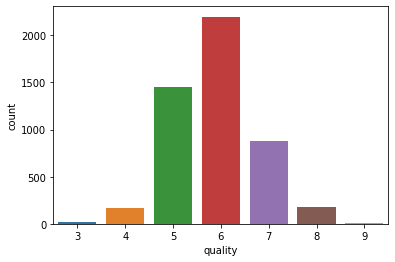

In [484]:
# 편향된 데이터임을 알 수 있다.
# quality 5, 6, 7이 압도적으로 많고, 1, 2, 10은 존재하지도 않는다.
sns.countplot(x = 'quality', data=df)

이 데이터는 quality값이 5, 6, 7이 압도적으로 많고 1, 2, 10은 존재하지도 않는 편향된 데이터다.<br>
따라서 학습 결과가 제대로 나오지 않을 수 있다.

In [485]:
col_list = next(csv.reader(open(wine_path), delimiter=','))

wineq_numpy.shape, col_list

((4898, 13),
 ['fixed acidity',
  'volatile acidity',
  'citric acid',
  'residual sugar',
  'chlorides',
  'free sulfur dioxide',
  'total sulfur dioxide',
  'density',
  'pH',
  'sulphates',
  'alcohol',
  'quality',
  'type'])

In [486]:
wineq = torch.from_numpy(wineq_numpy)

wineq.shape, wineq.dtype

(torch.Size([4898, 13]), torch.float32)

In [487]:
data = wineq[:, :-2] # <1>
data, data.shape

(tensor([[ 7.00,  0.27,  ...,  0.45,  8.80],
         [ 6.30,  0.30,  ...,  0.49,  9.50],
         ...,
         [ 5.50,  0.29,  ...,  0.38, 12.80],
         [ 6.00,  0.21,  ...,  0.32, 11.80]]), torch.Size([4898, 11]))

In [488]:
target = wineq[:, -2].type(torch.LongTensor) # <2>
target, target.shape

(tensor([6, 6,  ..., 7, 6]), torch.Size([4898]))

In [489]:
# 데이터 집합을 training data와 validation data로 분할
# validation data는 전체 데이터의 20%
train_X, val_X, train_Y, val_Y = train_test_split(data, target, test_size=0.2)

전체 데이터 집합을 training data와 validation data로 분할하였다.<br>
이때 validation data는 전체 데이터의 20%가 되도록 했다.

In [490]:
EPOCHS = 300
BATCH_SIZE = 100
LEARNING_RATE = 0.0001
FEATURE = 11
CLASS = 10

In [491]:
train = TensorDataset(train_X, train_Y)
val = TensorDataset(val_X, val_Y)

train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val, batch_size=1, shuffle=True )

In [492]:
# neural network
class Net(nn.Module):
  def __init__(self, num_feature, num_class):
    super(Net, self).__init__()
    self.layer1 = nn.Linear(num_feature, 280)
    self.layer2 = nn.Linear(280, 140)
    self.layer3 = nn.Linear(140, 70)
    self.layer_out = nn.Linear(70, num_class)

    self.tanh = nn.Tanh()
    self.dropout = nn.Dropout(p=0.5)
    self.batch_norm1 = nn.BatchNorm1d(280)
    self.batch_norm2 = nn.BatchNorm1d(140)
    self.batch_norm3 = nn.BatchNorm1d(70)
  
  def forward(self, x):
    x = self.layer1(x)
    x = self.batch_norm1(x)
    x = self.tanh(x)

    x = self.layer2(x)
    x = self.batch_norm2(x)
    x = self.tanh(x)
    self.dropout(x)

    x = self.layer3(x)
    x = self.batch_norm3(x)
    x = self.tanh(x)
    x = self.dropout(x)

    x = self.layer_out(x)

    return x


  

neural network를 모델링 하였다.<br>
layer1은 280개의 노드, layer2는 140개의 노드, layer3은 70개의 노드로 구성된다.<br>
overfitting을 해결하기 위해 dropout을 사용하였다.<br>
Gradient Vanishing / Gradient Exploding 문제를 해결하기 위해 batch normalization을 사용하였다.


In [493]:
model = Net(FEATURE, CLASS) # 신경망 클래스를 model이라는 객체에 저장
criterion = nn.CrossEntropyLoss() # 교차엔트로피로 오차를 계산하는 오차함수
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # Adam
print(model)

Net(
  (layer1): Linear(in_features=11, out_features=280, bias=True)
  (layer2): Linear(in_features=280, out_features=140, bias=True)
  (layer3): Linear(in_features=140, out_features=70, bias=True)
  (layer_out): Linear(in_features=70, out_features=10, bias=True)
  (tanh): Tanh()
  (dropout): Dropout(p=0.5, inplace=False)
  (batch_norm1): BatchNorm1d(280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(140, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [494]:
# 정확도
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

In [495]:
loss_arr = {
    'train': [],
    "val": []
}

acc_arr = {
    'train': [],
    "val": []
}

In [507]:
for epoch in range(EPOCHS):

  # training
  train_epoch_loss = 0
  train_epoch_acc = 0
  model.train()
  for train_X, train_Y in train_loader:
    train_X, train_Y = Variable(train_X), Variable(train_Y)
    optimizer.zero_grad()
    train_output = model(train_X)
    train_loss = criterion(train_output, train_Y)
    train_acc = multi_acc(train_output, train_Y)

    train_loss.backward()
    optimizer.step()
    train_epoch_loss += train_loss.item()
    train_epoch_acc += train_acc.item()
  

  # validation
  with torch.no_grad():
    val_epoch_loss = 0
    val_epoch_acc = 0
    model.eval()
    for val_X, val_Y in val_loader:
      val_X, val_Y = Variable(val_X), Variable(val_Y)
      val_output = model(val_X)

      val_loss = criterion(val_output, val_Y)
      val_acc = multi_acc(val_output, val_Y)

      val_epoch_loss += val_loss.item()
      val_epoch_acc += val_acc.item()
  
  loss_arr['train'].append(train_epoch_loss/len(train_loader))
  loss_arr['val'].append(val_epoch_loss/len(val_loader))
  acc_arr['train'].append(train_epoch_acc/len(train_loader))
  acc_arr['val'].append(val_epoch_acc/len(val_loader))

  if epoch%10 == 0:
    print("Epoch",epoch,":", "Train loss:", train_epoch_loss/len(train_loader), "Val loss:", val_epoch_loss/len(val_loader), "Train acc:", train_epoch_acc/len(train_loader), "Val acc:", val_epoch_acc/len(val_loader))


  

Epoch 0 : Train loss: 1.0403546333312987 Val loss: 1.0126967668685378 Train acc: 82.5 Val acc: 54.38775510204081
Epoch 10 : Train loss: 1.0196876913309096 Val loss: 0.992345969196485 Train acc: 95.0 Val acc: 58.97959183673469
Epoch 20 : Train loss: 1.02570533901453 Val loss: 0.9977185547655942 Train acc: 82.5 Val acc: 58.97959183673469
Epoch 30 : Train loss: 1.0171772420406342 Val loss: 1.014568931426929 Train acc: 87.5 Val acc: 56.42857142857143
Epoch 40 : Train loss: 1.0157854214310647 Val loss: 0.989997118681061 Train acc: 92.5 Val acc: 59.69387755102041
Epoch 50 : Train loss: 1.023623561859131 Val loss: 0.9873873091473871 Train acc: 85.0 Val acc: 59.183673469387756
Epoch 60 : Train loss: 1.007260364294052 Val loss: 0.9885579584508526 Train acc: 90.0 Val acc: 59.08163265306123
Epoch 70 : Train loss: 1.0095766097307206 Val loss: 0.9844300014784142 Train acc: 95.0 Val acc: 58.36734693877551
Epoch 80 : Train loss: 1.0000125125050545 Val loss: 0.9873221611338002 Train acc: 87.5 Val acc:

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

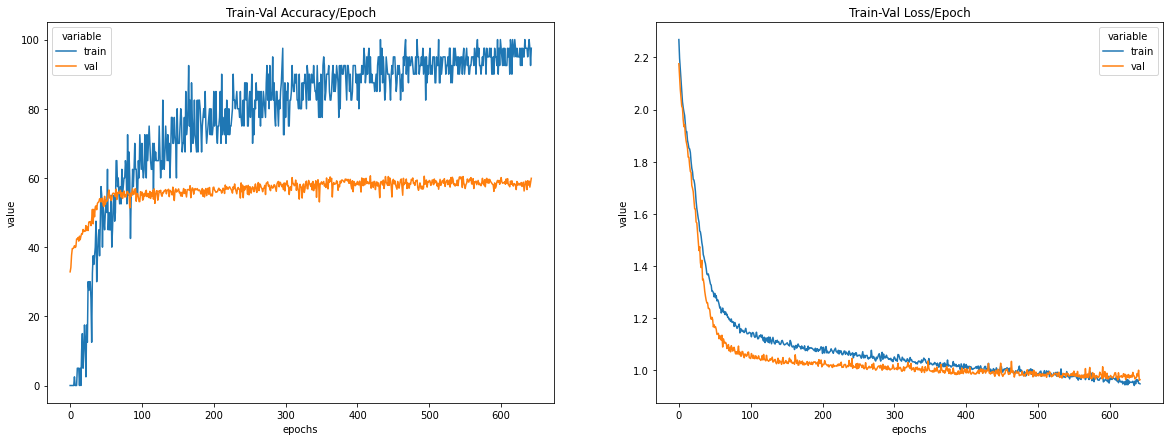

In [508]:
# 시각화
train_val_acc_df = pd.DataFrame.from_dict(acc_arr).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_arr).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

training loss, validation loss, training accuracy, validation accuracy를 시각화한 결과는 위와 같다.